# Multivariate Poisson Lognormal (MPLN) model
The MPLN model (?) relates some $p$-dimensional observation vectors $\boldsymbol{Y}_i$ to some $p$-dimensional vectors of Gaussian latent variables $Z_i$ as follows
$$
\begin{aligned}
& \boldsymbol{Y}_i\left|\boldsymbol{Z}_i \sim \operatorname{Poisson}\left(e^{Z_i}\right), \quad Y_{i j}\right| Z_{i j} \text { indep. } \\
& Z_i \sim \mathcal{N}\left(\boldsymbol{X}_i^{\top} \boldsymbol{B}_{d \times p}, \Sigma_{p \times p}\right)
\end{aligned}
$$
where
- $Y_{i j}$ represents the $j$ th code of $i$ th patient with $i=1, \cdots, n$ and $j=1, \cdots, p, \boldsymbol{Y}=\left(\boldsymbol{Y}_1, \cdots, \boldsymbol{Y}_n\right)^{\top} \in$ $\operatorname{Rn}^n \times p$
- $Z_i$ is the patient-level embedding of ith patient, $Z=\left(Z_1, \cdots, Z_n\right)^{\top} \in \mathbb{R}^{n \times p}$,
- $\boldsymbol{X}_i$ is the covariates of ith patient, $\boldsymbol{X}=\left(\boldsymbol{X}_1, \cdots, \boldsymbol{X}_n\right)^{\top} \in \mathbb{R}^{n \times d}$
## Leveraging external information for $\Sigma$
In the MPLN model, $\boldsymbol{\Sigma}$ describes the underlying residual relationships between the $p$ codes. We may decompose $\boldsymbol{\Sigma}=\boldsymbol{V} \boldsymbol{\Lambda} \boldsymbol{V}^{\top}$, where $\boldsymbol{V} \in \mathbb{R}^{p \times q}$ is orthonormal and the rank $q \leq p, \boldsymbol{\Lambda} \in \mathbb{R}^{q \times q}$ is diagonal. Assuming that across different institution/dataset, the orientation/rotation $(\boldsymbol{V})$ is the same but the shape/scaling $\boldsymbol{\Lambda}$ can be different, we may borrow $\boldsymbol{V}$ that is obtained from external sources for model estimation. In that case, instead of estimating the full covariance matrix $\mathbf{\Sigma}$, we only need to estimate the diagnol matrix $\boldsymbol{\Lambda}$.
An alternative way to write the model:
$$
\begin{aligned}
& \boldsymbol{Y}_i\left|\boldsymbol{Z}_i \sim \operatorname{Poisson}\left(e^{Z_i}\right) \quad, \quad Y_{i j}\right| Z_{i j} \text { indep. } \\
& \boldsymbol{Z}_i={\color{red}\boldsymbol{B}^\top\boldsymbol{X}_i + \boldsymbol{V} \boldsymbol{\Lambda}^{1 / 2}  \boldsymbol{W}_i } \quad, \\
& \boldsymbol{W}_i \sim \mathcal{N}\left(0_q, \boldsymbol{I}_{q \times q}\right) \quad \text { iid }
\end{aligned}
$$

## Joint likelihood
In matrix notation, $\boldsymbol{Z}=\boldsymbol{X} \boldsymbol{B}+\boldsymbol{W} \boldsymbol{\Lambda}^{1 / 2} \boldsymbol{V}^{\top}$. The observation matrix $\boldsymbol{Y}$ only depends on $\boldsymbol{Z}$ through $\boldsymbol{B}, \boldsymbol{\Lambda}$ and $\boldsymbol{W}$, and the complete log-likelihood is therefore
$$
\begin{aligned}
\log p(\boldsymbol{Y}, \boldsymbol{W} ; \boldsymbol{B}, \boldsymbol{\Lambda})= & \sum_{i=1}^n \log p\left(\boldsymbol{Y}_i \mid \boldsymbol{W}_i ; \boldsymbol{B}, \boldsymbol{\Lambda}\right)+\log p\left(\boldsymbol{W}_i\right) \\
= & \mathbf{1}_n^{\top}\left\{\boldsymbol{Y} \odot\left(\boldsymbol{X} \boldsymbol{B}+\boldsymbol{W} \boldsymbol{\Lambda}^{1 / 2} \boldsymbol{V}^{\top}\right)-\exp \left(\boldsymbol{X} \boldsymbol{B}+\boldsymbol{W} \boldsymbol{\Lambda}^{1 / 2} \boldsymbol{V}^{\top}\right)\right\} \mathbf{1}_p \\
& -\frac{\|\boldsymbol{W}\|_F^2}{2}-\frac{n q}{2} \log (2 \pi)-\mathbf{1}_n^{\top} \log (\boldsymbol{Y} !) \mathbf{1}_p
\end{aligned}
$$

## Computing the MAP for W_i
The estimate for $W_i$ is the maximizer of the above joint loglihood. It is also called the maximum a posteriori (the MAP). By observational independence each $W_i$ can be computed individually. What's more, by conditional independence (on W_i), the joint log-likelihood for $(Y_i, W_i)$ is

$$
\log p(Y_i, W_i; B, A) = \sum_{j=1}^p \log p(y_{ij}|W_i;B, A) + \log p(W_i) 
$$

With derivative with respect to $W_i$ :

$$
\nabla_{W_i} = \frac{\partial }{\partial W_i}\log p(Y_i, W_i ; \boldsymbol{B}, \boldsymbol{\Lambda}) =\\ \sum_{j=1}^p A^{1/2} V_j (y_{ij} - \exp(x_{i}^\top\beta_j + W_i^\top A^{1/2}V_j)) - W_i
$$

in matrix notations:

$$
\nabla_{W_i} =   A^{1/2} V^\top(Y_i - \exp(B^\top x_i + V A^{1/2} W_i )) - W_i
$$

Here the role of "covariates" are taken by $VA^{1/2}$ and that of  "parameters" by the $W_i$, with a l2-norm penalty in the $W_i$.

The hessian is

$$
\nabla^2_{W_i} = - (A^{1/2} V^\top \text{diag}(\exp(B^\top x_i + V A^{1/2} W_i )) V A^{1/2} + I_q)
$$

Solving for $W_i$ can be done by Newton method: starting at some value $W_i^{(t)}$, the next iterate is given by


$$
W_i^{(t+1)} = W_i^{(t)} - [\nabla^2_{W_i}]^{-1} \nabla_{W_i}, 
$$

alternatively, IRLS could be used. Now, this needs to be done for every $W_i$. Instead of computing a hessian matrix for all $i$, we can get its diagonal elements instead, and approximate the hessian by a diagonal matrix, yielding a quasi-newton method. These matrices are easy to obtain, specifically, the diagonal element $[\nabla^2_{W_i}]_{kk}$ is obtained as


$$
[\nabla^2_{W_i}]_{kk} = (A^{1/2} V_{\cdot k} \odot \mu_i ) ^\top A^{1/2} V_{\cdot k} \odot \mu_i  
$$

where $\mu_i = \exp(B^\top x_i + V A^{1/2} W_i ) $. The diagonal can be computed at once as 

(A1/2 V) *mu_i**2.sum(dim=0)

We can now use tensors to compute all diagonal elements at once






```python
diag_elements = 
```


This is easly computable for all $i$ simultaneously by




 Specifically, for each updating step, we need to compute $n$ hessian matrices.  



## 2.4 Simulation setting
Let $n=5000, p=50$. Consider two scenarios: true covariance has full rank and has low rank.
- Scenario 1 (true covariance with full rank):
1. Generate $\boldsymbol{\Sigma}=A R_1(0.8)$. Find its eigen-decomposition $\boldsymbol{\Sigma}=\boldsymbol{V} \boldsymbol{\Lambda} \boldsymbol{V}^{\top}$. 
2. Generate $\boldsymbol{Z} \sim \mathcal{N}(\mathbf{0}, \boldsymbol{\Sigma})$ and $\boldsymbol{Y} \sim \operatorname{Poisson}\left(e^{\boldsymbol{Z}}\right)$.
3. Fit model with $\boldsymbol{V}$,

    a. (correct) assuming $\boldsymbol{\Sigma}$ has full rank, $\boldsymbol{\Lambda} \in \mathbb{R}^{p \times p}$, we use the full $\boldsymbol{V}$ here.
    
    b. (low rank appriximation) assuming $\boldsymbol{\Sigma}$ has lower rank, $\Lambda \in \mathbb{R}^{q \times q}$ with $q=20,10,5$, we only use $\boldsymbol{V}_{[, 1: q]}$ here.

- Scenario 2 (true covariance with low rank, $q=12$ ):
1. Generate $\boldsymbol{\Sigma}=A R_1(0.8)$. Find its eigen-decomposition $\boldsymbol{\Sigma}=\boldsymbol{V} \boldsymbol{\Lambda} \boldsymbol{V}^{\top}$.
2. Let $\tilde{\boldsymbol{\Sigma}}=\boldsymbol{V}_{[, 1: q]} \boldsymbol{\Lambda}_{[1: q, 1: q]} \boldsymbol{V}_{[, 1: q]}^T$. Find its eigen-decomposition $\tilde{\mathbf{\Sigma}}=\tilde{\boldsymbol{V}} \tilde{\boldsymbol{\Lambda}}^{\top}$. This will be our true covariance with known rank $=q$. (In reality we observe $\bar{\Sigma}$ from external sources)
4. Fit model with $\vec{V}$.
a. (neglecting low-rankness) assuming $\Sigma$ has full rank, $\Lambda \in \mathbb{R}^{p \times p}$, we use the full $\tilde{V}$ here.
b. (correct) assuming $\Sigma$ has lower rank, $\Lambda \in \mathbb{R}^{q \times q}$ with $q=20,10,5$, we only use $\tilde{\boldsymbol{V}}_{[, 1: q]}$. here. (In reality we don't know the true rank, so would also need to implement a procedure to select for the best $q$.

## Some notes on implementation
* The $q\times q$ matrix $A$ is diagonal and its vector of diagonal elements $a$ must be strictly positive. This constraint identifies the model. To implement this constraint, at every iteration, if $a_j$ is negative , we multiply wlog both $a_j$ and the $j$ th latent variable $z_j$ by $-1$.

In [76]:
import numpy as np
import torch
from torch import nn

def gen_Sigma(num_features, rho=0.8):
    # AR1 parameters
    rho = 0.8  # Autocorrelation coefficient

    # Generate AR1 covariance matrix
    cov_matrix = rho ** np.abs(np.subtract.outer(np.arange(num_features), np.arange(num_features)))

    # Perform eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    sort_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sort_indices]
    eigenvectors = eigenvectors[:, sort_indices]

    # Calculate V and A
    V = eigenvectors
    a = eigenvalues


    return cov_matrix, V, a

def gen_X(n, num_covariates):
    return torch.randn((n, num_covariates))


In [77]:
class MPLN(nn.Module):
    def __init__(self, num_latents, num_features, num_covariates, V):
        super().__init__()
        self.num_latents = num_latents
        self.num_features = num_features
        self.num_covariates = num_covariates
        self.V = V
        self.encoder = Encoder(num_features, num_covariates, num_latents, num_hidden=100)

        # Initialize parameters
        self.B = nn.Parameter(torch.zeros((num_features, num_covariates)))
        self.a = nn.Parameter(torch.ones((num_latents)))
    
    def forward(self, W, X=None, invlink=None):
        if X is None:
            X = torch.zeros((W.shape[0], 0))
        # Get the linpar (Z above) from the eigendecomposition
        linpar = X @ self.B.T + W @ torch.diag(self.a.sqrt()) @ self.V.T
        condmean = linpar if invlink is None else invlink(linpar)
        return linpar, condmean

    def sample(self, n, X=None, poisson=True):
        with torch.no_grad():
            W = torch.randn((n, self.num_latents))

            if poisson is True:
                _, condmean = self(W, X, invlink=torch.exp)
                Y = torch.poisson(condmean).float()
            else:
                _, Y = self(W, X)

        return {'W': W, 'Y':Y}

class Encoder(nn.Module):
    def __init__(self, num_features, num_covariates, num_latents, num_hidden):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(num_features + num_covariates, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_latents))
    
    def forward(self, X, Y):
        # contaenate X and Y 
        XY = torch.cat((X, Y), dim=1)
        return self.fc(XY)

def train_encoder(X, Y, Z, model, optimizer, criterion, num_epochs=100,validation_data=None, verbose=True, random=False, **kwargs):
    """
    Train a PyTorch model and return the model and the history of losses.

    :param x: The input data for model
    :param y: The labels for input data
    :param z: additional input data
    :param u: additional input data
    :param model: PyTorch model to train
    :param optimizer: Optimizer to use in training
    :param criterion: Loss function to use in training
    :param num_epochs: Number of training epochs. Default is 100.
    :param validation_data: Tuple of validation data (x_val, y_val, z_val, u_val). Default is None.
    :return: Tuple of trained model and history of losses.
    """
    # Switch model to training mode
    model.train()
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass
        outputs_z = model.encoder(X, Y)

        loss = criterion(outputs_z, Z)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if validation_data is not None:
            model.eval() # switch model to evaluation mode
            with torch.no_grad():
                z_val, y_val  = validation_data.values()
                val_z = model.encoder(X, y_val)
                val_loss =  criterion(val_z, z_val)
                val_losses.append(val_loss.item())
            model.train() # switch model back to training mode

        if verbose and (epoch % 10) == 0:
            print(f'Epoch: {epoch}, Training Loss: {loss.item()}, Val loss = {None if validation_data is None else val_loss}')

    return model, train_losses, val_losses



# generate data
# -------------
n = 5000
num_features = 50
num_covariates = 0
num_latents = 5

Sigma, V, A = gen_Sigma(num_features, rho=0.8)
model = MPLN(num_latents, num_features, num_covariates, V[:,:num_latents])
X = gen_X(n, num_covariates)
dat_true = model.sample(n, X, poisson=True)
dat_val = model.sample(n, X, poisson=True)

In [78]:
optimizer = torch.optim.Adam(model.encoder.parameters(), lr=0.01)
criterion = nn.MSELoss()


In [79]:

_ = train_encoder(X, dat_true['Y'], dat_true['W'], model=model, optimizer=optimizer, criterion=criterion, num_epochs=500, validation_data=dat_val)

Epoch: 0, Training Loss: 1.0122543573379517, Val loss = 0.9610810875892639
Epoch: 10, Training Loss: 0.6661685109138489, Val loss = 0.6488306522369385
Epoch: 20, Training Loss: 0.565086305141449, Val loss = 0.5954761505126953
Epoch: 30, Training Loss: 0.5230598449707031, Val loss = 0.566157877445221
Epoch: 40, Training Loss: 0.5083904266357422, Val loss = 0.5541267395019531
Epoch: 50, Training Loss: 0.47597914934158325, Val loss = 0.5543708801269531
Epoch: 60, Training Loss: 0.46197161078453064, Val loss = 0.5451619029045105
Epoch: 70, Training Loss: 0.4447692930698395, Val loss = 0.5464577078819275
Epoch: 80, Training Loss: 0.4327811300754547, Val loss = 0.5520853400230408
Epoch: 90, Training Loss: 0.4262506663799286, Val loss = 0.5559964776039124
Epoch: 100, Training Loss: 0.4124489426612854, Val loss = 0.5642643570899963
Epoch: 110, Training Loss: 0.40321749448776245, Val loss = 0.5807278752326965
Epoch: 120, Training Loss: 0.39319083094596863, Val loss = 0.5792719125747681
Epoch: 1

KeyboardInterrupt: 

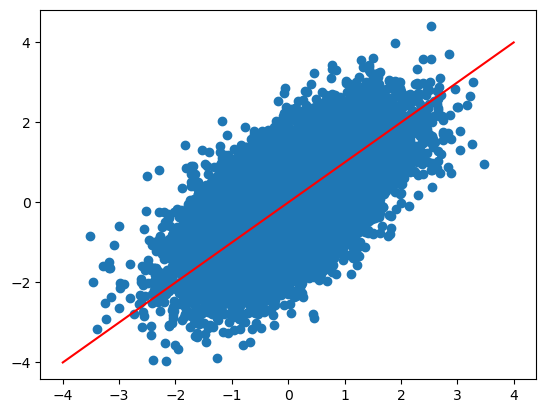

In [80]:
import matplotlib.pyplot as plt

dat_sample = model.sample(n, X=X, poisson=True)
what = model.encoder(X, dat_sample['Y']).detach().numpy()
w_true = dat_sample['W'].detach().numpy()

plt.scatter(what, w_true)
plt.plot([-4,4], [-4,4], color="red")

In [18]:
nn.Parameter(torch.zeros((10,0)))

Parameter containing:
tensor([], size=(10, 0), requires_grad=True)

In [4]:
import numpy as np

# Define matrix A
A = np.array([[1, 2], [3, 4]])

# Perform eigen decomposition
eigenvalues, eigenvectors = np.linalg.eig(A)

# Print eigenvalues and eigenvectors
print("Eigenvalues:")
print(eigenvalues)
print("Eigenvectors:")
print(eigenvectors)

Eigenvalues:
[-0.37228132  5.37228132]
Eigenvectors:
[[-0.82456484 -0.41597356]
 [ 0.56576746 -0.90937671]]


In [8]:
eigenvectors

array([[ 1.        , -0.17149859],
       [-0.17149859,  1.        ]])